In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Extract Data

In [2]:
df = pd.read_csv('../../Tensorflow 2/TF_2_Notebooks_and_Data/DATA/Frozen_Dessert_Production.csv',
                 index_col='DATE', parse_dates=True)

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


# Rename Column

In [4]:
df.columns = ['Production']

In [5]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


# Train Test Split

In [6]:
test_size = 24

In [7]:
train_ind = len(df) - test_size

In [8]:
train = df[:train_ind]
test = df[train_ind:]

In [9]:
train.tail()

,Production
DATE,
2017-05-01,116.0635
2017-06-01,123.0870
2017-07-01,116.2639
2017-08-01,113.1717
2017-09-01,97.9125


In [10]:
test.head()

,Production
DATE,
2017-10-01,90.4732
2017-11-01,77.4378
2017-12-01,75.8118
2018-01-01,83.4343
2018-02-01,99.4899


# Scale Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
scaled_train = scaler.fit_transform(train)

In [14]:
scaled_test = scaler.transform(test)

# Time Series Generator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 18

In [19]:
n_features = 1

In [20]:
generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=length, batch_size=1)

In [21]:
validation_generator = TimeseriesGenerator(data=scaled_test, targets=scaled_test, length=length, batch_size=1)

# Create the Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [23]:
model = Sequential()

model.add(LSTM(100, input_shape=(length, n_features), activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

# Create EarlyStopping

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Train the model

In [26]:
model.fit(generator, validation_data=validation_generator, callbacks=[early_stop], epochs=20)

Epoch 1/20
531/531 [==============================] - 5s 9ms/step - loss: 0.0254 - val_loss: 0.0032
Epoch 2/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0086 - val_loss: 0.0014
Epoch 3/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 4/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0036 - val_loss: 0.0020


In [34]:
# model.save('RNN_test_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: RNN_test_model\assets


In [27]:
from tensorflow.keras.models import load_model

In [39]:
pre_saved_model = load_model('RNN_test_model')


# Evaluate on Test Data

In [28]:
losses = pd.DataFrame(model.history.history)

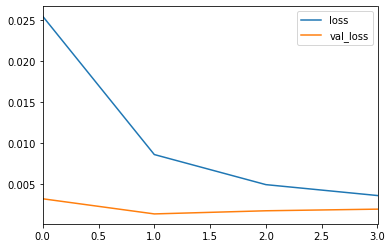

In [29]:
losses.plot()

# Prediction

In [30]:
length

18

In [31]:
len(test)

24

In [32]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1, length, 1)

In [33]:
current_batch.shape

(1, 18, 1)

In [34]:
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [35]:
test_predictions

[array([0.19682002], dtype=float32),
 array([0.16224986], dtype=float32),
 array([0.20179436], dtype=float32),
 array([0.2805557], dtype=float32),
 array([0.3448264], dtype=float32),
 array([0.39735797], dtype=float32),
 array([0.43205178], dtype=float32),
 array([0.44330278], dtype=float32),
 array([0.42313176], dtype=float32),
 array([0.370172], dtype=float32),
 array([0.28590482], dtype=float32),
 array([0.19638515], dtype=float32),
 array([0.12786342], dtype=float32),
 array([0.1404303], dtype=float32),
 array([0.20903191], dtype=float32),
 array([0.28535026], dtype=float32),
 array([0.34413785], dtype=float32),
 array([0.38586882], dtype=float32),
 array([0.40618804], dtype=float32),
 array([0.40098065], dtype=float32),
 array([0.36077413], dtype=float32),
 array([0.28952852], dtype=float32),
 array([0.2035738], dtype=float32),
 array([0.12215791], dtype=float32)]

In [36]:
true_predictions = scaler.inverse_transform(test_predictions)

In [37]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [38]:
len(true_predictions)

24

In [39]:
test['Predictions'] = true_predictions

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


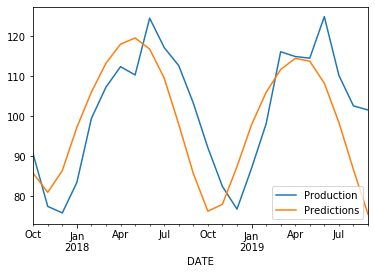

In [40]:
test.plot()

# Calculate RMSE

In [61]:
from sklearn.metrics import mean_squared_error

In [63]:
np.sqrt(mean_squared_error(test['Production'], test['Predictions']))


10.699676160361838